In [307]:
using DifferentialEquations, PyPlot, Statistics, LaTeXStrings, PyCall, LinearAlgebra, FFTW

In [2]:
ENV["PYTHON"] = "C:\\Users\\admin\\Anaconda3\\envs\\data_vis\\python.exe"

LogNorm = pyimport("matplotlib.colors").LogNorm
cmap = pyimport("cmap")

lajolla = cmap.Colormap("crameri:lajolla").to_mpl();
balance = cmap.Colormap("cmocean:balance").to_mpl();
oslo = cmap.Colormap("crameri:oslo").to_mpl();
lipari = cmap.Colormap("crameri:lipari").to_mpl();
eclipse = cmap.Colormap("cmasher:eclipse").to_mpl();

# Configure LaTeX rendering and fonts
PyPlot.matplotlib[:rc]("text", usetex=true)
PyPlot.matplotlib[:rc]("font", family="serif", serif=["mathpazo"], size=18)  # Base font size
PyPlot.matplotlib[:rc]("axes", titlesize=30)             # Axis title
PyPlot.matplotlib[:rc]("axes", labelsize=30)             # Axis labels
PyPlot.matplotlib[:rc]("xtick", labelsize=24)            # X-ticks
PyPlot.matplotlib[:rc]("ytick", labelsize=24)            # Y-ticks
PyPlot.matplotlib[:rc]("legend", fontsize=24)            # Legend
PyPlot.matplotlib[:rc]("figure", titlesize=24)           # Figure title
PyPlot.svg(true)
# LaTeX preamble packages
PyPlot.matplotlib[:rc]("text.latex", preamble="\\usepackage{amsmath}\\usepackage{amsfonts}\\usepackage{amssymb}\\usepackage{lmodern}")

In [3]:
# Define the system of ODEs
function coupled_eqs!(du, u, p, t)
    Δ1, Δ2, g, φ, Δ, κ, η = p
    s1x, s1y, s1z, s2x, s2y, s2z, α_re, α_im = u

    α = α_re + im * α_im
    α_star = conj(α)
    exp_iφ = cos(φ) + im * sin(φ)
    exp_minus_iφ = conj(exp_iφ)

    du[1] = Δ1 * s1y + im* g * s1z * (α - α_star)  # s1x_dot
    du[2] = -Δ1 * s1x - g * s1z * (α_star + α)  # s1y_dot
    du[3] = -im* g * s1x * (α - α_star) + g * s1y * (α_star + α)  # s1z_dot

    du[4] = Δ2 * s2y + im* g * s2z * (exp_iφ * α - exp_minus_iφ * α_star)  # s2x_dot
    du[5] = -Δ2 * s2x - g * s2z * (exp_minus_iφ * α_star + exp_iφ * α)  # s2y_dot
    du[6] = -im* g * s2x * (exp_iφ * α - exp_minus_iφ * α_star) + g * s2y * (exp_minus_iφ * α_star + exp_iφ * α)  # s2z_dot

    dα = (Δ * im - κ / 2) * α - (g / 2) * (im * (s1x + exp_minus_iφ * s2x) + (s1y + exp_minus_iφ * s2y)) + η
    du[7] = real(dα)  # Re(α_dot)
    du[8] = imag(dα)  # Im(α_dot)
end

# Define the system of ODEs WHEN CAVITY IS ELIMINATED
function spin_only_coupled_eqs!(du, u, p, t)
    Δ1, Δ2, g, φ, Δ, κ, η = p
    s1x, s1y, s1z, s2x, s2y, s2z = u

    # Derived parameters
    K = κ / 2
    Δ_plus = Δ * cos(φ) + K * sin(φ)
    Δ_minus = Δ * cos(φ) - K * sin(φ)
    K_plus = K * cos(φ) + Δ * sin(φ)
    K_minus = K * cos(φ) - Δ * sin(φ)
    𝒥 = g^2 / (Δ^2 + K^2)  # 𝒥 = g²/(Δ² + (κ/2)²)

    # Equations for s1x, s1y, s1z, s2x, s2y, s2z
    du[1] = Δ1 * s1y + s1z * 𝒥 * (Δ * s1y + K * s1x + K_plus * s2x + Δ_minus * s2y - 2 * Δ * η / g)
    du[2] = -Δ1 * s1x + s1z * 𝒥 * (-Δ * s1x + K * s1y - Δ_minus * s2x + K_plus * s2y - 2 * K * η / g)
    du[3] = -𝒥 * (
        -2 * η / g * (K * s1y + Δ * s1x) +
        K * (s1x^2 + s1y^2) +
        K_plus * s1x * s2x +
        Δ_minus * s1x * s2y -
        Δ_minus * s1y * s2x +
        K_plus * s1y * s2y
    )
    du[4] = Δ2 * s2y + s2z * 𝒥 * (Δ * s2y + K * s2x + K_minus * s1x + Δ_plus * s1y - 2 * Δ_plus * η / g)
    du[5] = -Δ2 * s2x + s2z * 𝒥 * (-Δ * s2x + K * s2y - Δ_plus * s1x + K_minus * s1y - 2 * K_minus * η / g)
    du[6] = -𝒥 * (
        -2 * η / g * (K_minus * s2y + Δ_plus * s2x) +
        K * (s2x^2 + s2y^2) +
        K_minus * s2x * s1x +
        Δ_plus * s2x * s1y -
        Δ_plus * s2y * s1x +
        K_minus * s2y * s1y 
    )
end


spin_only_coupled_eqs! (generic function with 1 method)

In [34]:
1500/((4*g^2/κ))



37499.99999999999

In [599]:
# Run sample simulation

Δ = 0.0
ϕ = 0

κ = 1.0
g = 0.1*κ
η = 1.5*g
Δ1 = 0.1g
Δ2 = 0.1g

# Time steps
Gamma = 4*g^2/κ
tend = 15/Gamma
t_list = range(0.0, tend, length=200)

u0c = [1, 0, 0, 1, 0, 0, 0, 0];
params = (Δ1, Δ2, g, ϕ, Δ, κ, η)

prob = ODEProblem(coupled_eqs!, u0c, (0.0, tend), params)
sol = solve(prob, Tsit5(), saveat=t_list, reltol=1e-6, abstol=1e-9, maxiters=1e10)

# Extract data from time steps 6000 to 10000
# range_idx = 60000:100000

ephi = exp(-im*ϕ)
# s_α_sq  = @. abs2(( ( g/2 * (im*(sol[1, range_idx] + ephi*sol[4, range_idx]) + (sol[2, range_idx] + ephi*sol[5, range_idx])) - η ) / (im * Δ - κ/2)));
sx1 = sol[1, :];
sy1 = sol[2, :];
sz1 = sol[3, :];
sx2 = sol[4, :];
sy2 = sol[5, :];
sz2 = sol[6, :];
α_re = sol[7,:];
α_im = sol[8,:];
α = α_re + im * α_im;
adaga = α .* conj(α);

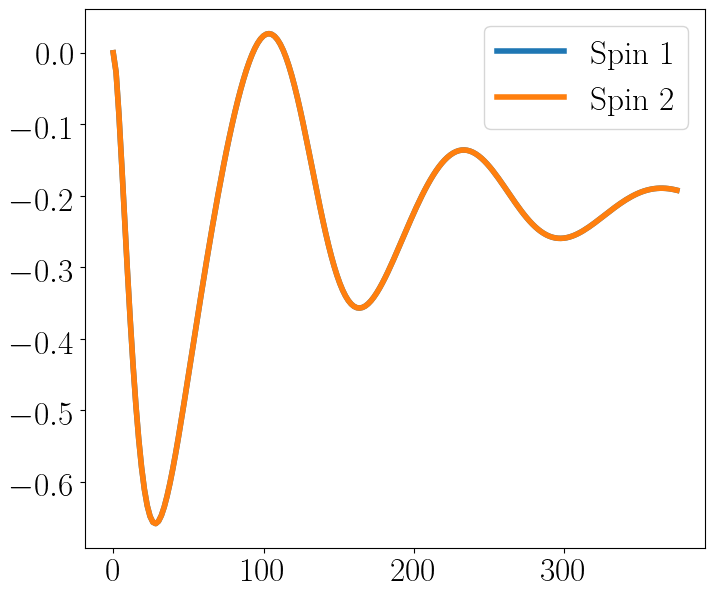

In [600]:
fig, axs = subplots(1, 1, figsize=(8, 7))


axs.plot(sol.t, sz1, lw=4, label = "Spin 1")
axs.plot(sol.t, sz2, lw=4, label = "Spin 2")
# axs.set_ylim(-1,1)
# axs.plot(sol.t,adaga, lw=4)
# axs.set_yscale("log")
# axs.set_ylim(1e-7,1e1)
# axs.set_xlim(0,15/g)
axs.legend()
display(fig)

In [601]:
using DelimitedFiles

# Save sz1 to a text file
writedlm("../finsize_data/mf_data4s1.txt", sz1)
writedlm("../finsize_data/mf_data4s2.txt", sz2)

In [56]:
# Fixed parameters
Δ1, Δ2 = 0.1, 0.1
g, κ = 0.1, 1.0
Δ = 0.0

# Time steps
tend = 1000/g
t_list = range(0.0, tend, length=100001)

# Initial conditions
u0c = [1, 0.0, 0, 1, 0.0, 0, 0, 0];
u0s = [1, 0, 0.0, 1, 0, 0.0];

In [ ]:
 
# Parameter ranges
η_vals = range(0.1*g, 1.5 * g, length=101)
φ_vals = range(-π, π, length=101)


# Store results
avg_alpha_sq = zeros(length(φ_vals), length(η_vals))
s_avg_alpha_sq = zeros(length(φ_vals), length(η_vals))
avg_sz1 = zeros(length(φ_vals), length(η_vals))
avg_sz2 = zeros(length(φ_vals), length(η_vals))
var_sz1 = zeros(length(φ_vals), length(η_vals))
var_sz2 = zeros(length(φ_vals), length(η_vals))
var_sx1 = zeros(length(φ_vals), length(η_vals))
var_sx2 = zeros(length(φ_vals), length(η_vals))
var_sy1 = zeros(length(φ_vals), length(η_vals))
var_sy2 = zeros(length(φ_vals), length(η_vals))


s1_2 = zeros(length(φ_vals), length(η_vals))
s2_2 = zeros(length(φ_vals), length(η_vals))

spin_corr = zeros(length(φ_vals), length(η_vals))

# Solve ODE for each η and φ
for (i, φ) in enumerate(φ_vals)
# for (i, Δ) in enumerate(Δ_vals)
    ephi = exp(-im*φ)
    for (j, η) in enumerate(η_vals)
    
        params = (Δ1, Δ2, g, φ, Δ, κ, η)
        prob = ODEProblem(coupled_eqs!, u0c, (0.0, tend), params)
        sol = solve(prob, Tsit5(), saveat=t_list, reltol=1e-6, abstol=1e-9)

        # Extract data from time steps 6000 to 10000
        range_idx = 60000:100000
        
        α_sq = sol[7, range_idx].^2 + sol[8, range_idx].^2  # |α|²
        #s_α_sq  = @. abs2(( ( g/2 * (im*(sol[1, range_idx] + ephi*sol[4, range_idx]) + (sol[2, range_idx] + ephi*sol[5, range_idx])) - η ) / (im * Δ - κ/2)))
        sx1 = sol[1, range_idx]
        sy1 = sol[2, range_idx]
        sz1 = sol[3, range_idx]
        sx2 = sol[4, range_idx]
        sy2 = sol[5, range_idx]
        sz2 = sol[6, range_idx]
        sz1_sz2 = sol[3, range_idx] .* sol[6, range_idx]

        # Spin length
        s1_2[i,j]= mean(sol[1, range_idx].^2 + sol[2, range_idx].^2 + sol[3, range_idx].^2)
        s2_2[i,j]= mean(sol[4, range_idx].^2 + sol[5, range_idx].^2 + sol[6, range_idx].^2)
        
        # Cavity and spin observables
        avg_alpha_sq[i, j] = mean(α_sq)
        #s_avg_alpha_sq[i,j] = mean(s_α_sq)
        var_sz1[i, j] = var(sz1)
        var_sz2[i, j] = var(sz2)
        var_sx1[i, j] = var(sx1)
        var_sx2[i, j] = var(sx2)
        var_sy1[i, j] = var(sy1)
        var_sy2[i, j] = var(sy2)
        avg_sz1[i, j] = mean(sz1)
        avg_sz2[i, j] = mean(sz2)

        #Spin correlations
        avg_sz1_sz2 = mean(sz1_sz2)
        spin_corr[i, j] = avg_sz1_sz2 - avg_sz1[i, j] * avg_sz2[i, j]
        
    end
end

In [59]:
using DelimitedFiles

# writedlm("vars_sz1_nodet.txt", var_sz1)
# writedlm("vars_sz2_nodet.txt", var_sz2)

writedlm("vars_sz1_wdet.txt", var_sz1)
writedlm("vars_sz2_wdet.txt", var_sz2)

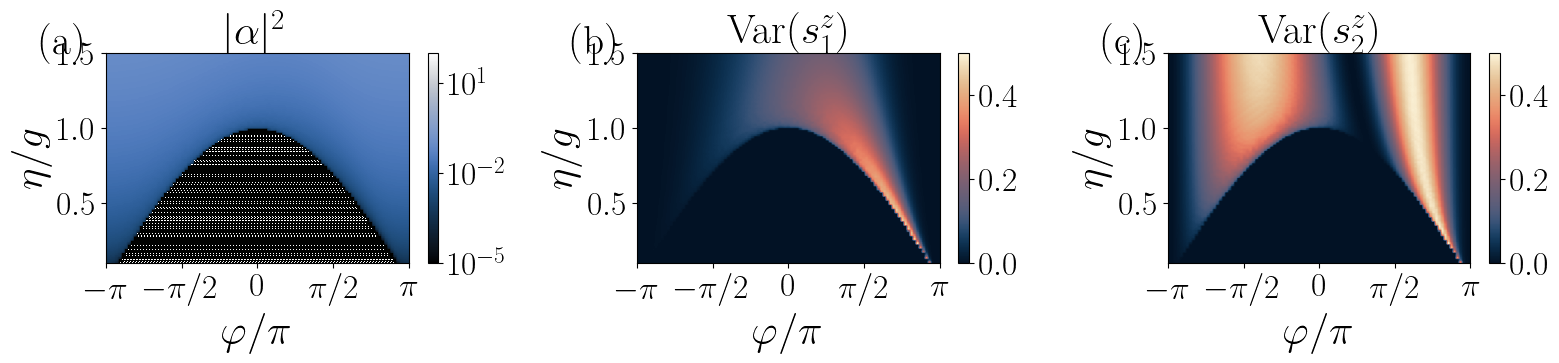

In [7]:
x = φ_vals./π
y = η_vals./g



xtick_locs = [-1.0, -0.5, 0.0, 0.5, 1.0]  # x = φ/π
xtick_labels = [L"-\pi", L"-\pi/2", L"0", L"\pi/2", L"\pi"]


fig, axs = subplots(1, 3, figsize=(16, 4))

# p1: Plot log10(<|α|²>)
im1 = axs[1].imshow(avg_alpha_sq',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto",
                     cmap=oslo,         # Use your defined colormap
                     norm=LogNorm(vmin=1e-5, vmax=1e2))     # Color limits
axs[1].set_ylabel(L"\eta/g")
axs[1].set_xlabel(L"\varphi/\pi")
axs[1].set_title(L"|\alpha|^2")
axs[1].set_xticks(xtick_locs)
axs[1].set_xticklabels(xtick_labels)
colorbar(im1, ax=axs[1])
axs[1].text(-0.22, 1.15, "(a)", transform=axs[1].transAxes, fontsize=30, fontweight="bold", va="top", ha="left")
# p2: Plot Var s₁ᶻ
im2 = axs[2].imshow(var_sz1',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto",
                     cmap=lipari,        # Use your defined colormap
                     vmin=0, vmax=0.5)    # Color limits
axs[2].set_ylabel(L"\eta/g")
axs[2].set_xlabel(L"\varphi/\pi")
axs[2].set_title(L"\mathrm{Var}(s_1^z)")
axs[2].set_xticks(xtick_locs)
axs[2].set_xticklabels(xtick_labels)
colorbar(im2, ax=axs[2])
axs[2].text(-0.22, 1.15, "(b)", transform=axs[2].transAxes, fontsize=30, fontweight="bold", va="top", ha="left")
# p3: Plot Var s₂ᶻ
im3 = axs[3].imshow(var_sz2',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto",
                     cmap=lipari,       
                     vmin=0, vmax=0.5)    
axs[3].set_ylabel(L"\eta/g")
axs[3].set_xlabel(L"\varphi/\pi")
axs[3].set_title(L"\mathrm{Var}(s_2^z)")
axs[3].set_xticks(xtick_locs)
axs[3].set_xticklabels(xtick_labels)
colorbar(im3, ax=axs[3])
axs[3].text(-0.22, 1.15, "(c)", transform=axs[3].transAxes, fontsize=30, fontweight="bold", va="top", ha="left")

# Adjust layout for better spacing
tight_layout()

# Save the figure as a PDF file
# plt.savefig("phased_g,kap=01,1_Del=0_Ds=01.pdf", format="pdf", bbox_inches="tight")

display(fig)

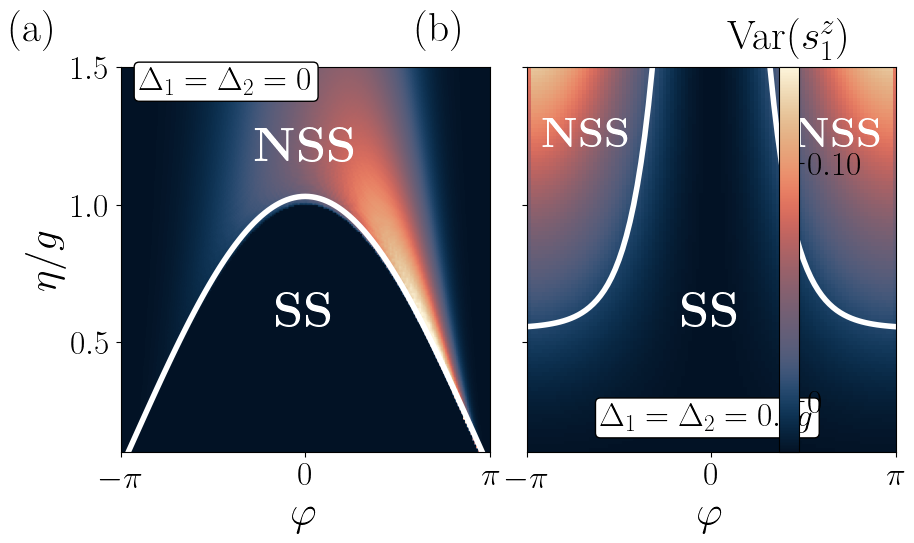

In [ ]:
x = φ_vals./π
y = η_vals./g

data1 = readdlm("vars_sz1_nodet.txt")
data2 = readdlm("vars_sz1_wdet.txt")

clims1 = (0,0.4)
clims2 = (0,0.15)

xtick_locs = [-1.0, 0.0, 1.0]  # x = φ/π
xtick_labels = [L"-\pi",L"0", L"\pi"]


fig, axs = subplots(1, 2, figsize=(10, 5))


im1 = axs[1].imshow(data1',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto",
                     cmap=lipari,        # Use your defined colormap
                     clim=clims1)    # Color limits
axs[1].set_ylabel(L"\eta/g")
axs[1].set_xlabel(L"\varphi")
axs[1].set_xticks(xtick_locs)
axs[1].set_xticklabels(xtick_labels)
# cbar1 = colorbar(im1, ax=axs[1])
# cbar1.ax.set_title(L"\mathrm{Var}(s_1^z)", pad=13)
# cbar1.set_ticks([0.02, 0.3])
# cbar1.set_ticklabels([L"0", L"0.3"])

fncx = (0.88.* cos.(1.08 .*x .* pi/2) .+ 0.15)
axs[1].plot(x, fncx, color = "white", linewidth = 4)
axs[1].set_ylim(0.1,1.5)
axs[1].text(-0.3, 1.15, "(a)", transform=axs[1].transAxes, fontsize=30, fontweight="bold", va="top", ha="left")

axs[1].text(
    0.05, 1, L"\Delta_1=\Delta_2=0",
    transform = axs[1].transAxes,
    fontsize = 24,
    va = "top",
    ha = "left",
    bbox = Dict(
        "facecolor"  => "white",
        "edgecolor"  => "black",
        "boxstyle"   => "round,pad=0.15"
    )
)
axs[2].text(
    0.2, 0.05, L"\Delta_1=\Delta_2=0.1g",
    transform = axs[2].transAxes,
    fontsize = 24,
    va = "bottom",
    ha = "left",
    bbox = Dict(
        "facecolor"  => "white",
        "edgecolor"  => "black",
        "boxstyle"   => "round,pad=0.15"
    )
)


im1 = axs[2].imshow(data2',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto",
                     cmap=lipari,        # Use your defined colormap
                     clim=clims2)    # Color limits
axs[2].set_xlabel(L"\varphi")
axs[2].set_xticks(xtick_locs)
axs[2].set_xticklabels(xtick_labels)

#Remove y labels keeping only ticks from axs[2]
axs[2].set_yticklabels([])

#oush colorbar position to the right 


cbar1 = colorbar(im1, ax=axs)
cbar1.ax.set_title(L"\mathrm{Var}(s_1^z)", pad=13)
cbar1.set_ticks([0.02, clims2[2]*0.75])
cbar1.set_ticklabels([L"0", L"0.10"])
axs[2].text(-0.3, 1.15, "(b)", transform=axs[2].transAxes, fontsize=30, fontweight="bold", va="top", ha="left")


fncx2 = 10(exp.(-4.7abs.(x .* pi/2))) .+ 0.55
axs[2].plot(x, fncx2, color = "white", linewidth = 4)
axs[2].set_ylim(0.1,1.5)


axs[1].text(0.0, 0.6, L"\textbf{SS}",
         fontsize = 35, ha = "center", va = "center", color = "white")
axs[1].text(0.0, 1.2, L"\textbf{NSS}",
         fontsize = 35, ha = "center", va = "center", color = "white")
axs[2].text(0.0, 0.6, L"\textbf{SS}",
         fontsize = 35, ha = "center", va = "center", color = "white")
axs[2].text(0.69, 1.25, L"\textbf{NSS}",
         fontsize = 30, ha = "center", va = "center", color = "white")
axs[2].text(-0.68, 1.25, L"\textbf{NSS}",
         fontsize = 30, ha = "center", va = "center", color = "white")

fig.subplots_adjust(wspace = 0.10)
# tight_layout()

# plt.savefig("phased_g,kap=01,1_Del=0_Ds=01.pdf", format="pdf", bbox_inches="tight")

display(fig)

#plt.savefig("../figs_for_paper/fig2.svg", bbox_inches="tight")


In [ ]:
x = φ_vals./π
y = η_vals./g

xtick_locs = [-1.0, -0.5, 0.0, 0.5, 1.0]  # x = φ/π
xtick_labels = [L"-\pi", L"-\pi/2", L"0", L"\pi/2", L"\pi"]


fig, axs = subplots(1, 2, figsize=(9, 3))

# p2: Plot avg s₁ᶻ
im2 = axs[1].imshow(avg_sz1',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto",
                     cmap=lipari,        # Use your defined colormap
                     vmin=-1, vmax=1)    # Color limits
axs[1].set_ylabel(L"\eta/g")
axs[1].set_xlabel(L"\varphi/\pi")
axs[1].set_title(L"\langle s_1^z\rangle")
axs[1].set_xticks(xtick_locs)
axs[1].set_xticklabels(xtick_labels)
colorbar(im2, ax=axs[1])
axs[1].text(-0.22, 1.15, "(a)", transform=axs[1].transAxes, fontsize=22, fontweight="bold", va="top", ha="left")
# p3: Plot avg s₂ᶻ
im3 = axs[2].imshow(avg_sz2',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto",
                     cmap=lipari,       
                     vmin=-1, vmax=1)    
axs[2].set_ylabel(L"\eta/g")
axs[2].set_xlabel(L"\varphi/\pi")
axs[2].set_title(L"\langle s_2^z\rangle")
axs[2].set_xticks(xtick_locs)
axs[2].set_xticklabels(xtick_labels)
colorbar(im3, ax=axs[2])
axs[2].text(-0.22, 1.15, "(b)", transform=axs[2].transAxes, fontsize=22, fontweight="bold", va="top", ha="left")

# Adjust layout for better spacing
tight_layout()

# Save the figure as a PDF file
#plt.savefig("mz_phased_g02_Delta02.pdf", format="pdf", bbox_inches="tight")

display(fig)

In [ ]:
x = φ_vals./π
y = η_vals./g

xtick_locs = [-1.0, -0.5, 0.0, 0.5, 1.0]  # x = φ/π
xtick_labels = [L"-\pi", L"-\pi/2", L"0", L"\pi/2", L"\pi"]


fig, axs = subplots(1, 4, figsize=(15, 3))


im1 = axs[1].imshow(var_sx1',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto",
                     cmap=lipari,        # Use your defined colormap
                     vmin=0, vmax=0.5)    # Color limits
axs[1].set_ylabel(L"\eta/g")
axs[1].set_xlabel(L"\varphi/\pi")
axs[1].set_title(L"\mathrm{Var}(s_1^x)")
axs[1].set_xticks(xtick_locs)
axs[1].set_xticklabels(xtick_labels)
colorbar(im1, ax=axs[1])
axs[1].text(-0.22, 1.15, "(a)", transform=axs[1].transAxes, fontsize=22, fontweight="bold", va="top", ha="left")
# p3: Plot avg s₂ᶻ
im2 = axs[2].imshow(var_sx2',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto",
                     cmap=lipari,       
                     vmin=0, vmax=0.5)    
axs[2].set_ylabel(L"\eta/g")
axs[2].set_xlabel(L"\varphi/\pi")
axs[2].set_title(L"\mathrm{Var}(s_2^x)")
axs[2].set_xticks(xtick_locs)
axs[2].set_xticklabels(xtick_labels)
colorbar(im2, ax=axs[2])
axs[2].text(-0.22, 1.15, "(b)", transform=axs[2].transAxes, fontsize=22, fontweight="bold", va="top", ha="left")

im3 = axs[3].imshow(var_sy1',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto",
                     cmap=lipari,       
                     vmin=0, vmax=0.5)    
axs[3].set_ylabel(L"\eta/g")
axs[3].set_xlabel(L"\varphi/\pi")
axs[3].set_title(L"\mathrm{Var}(s_1^y)")
axs[3].set_xticks(xtick_locs)
axs[3].set_xticklabels(xtick_labels)
colorbar(im3, ax=axs[3])
axs[3].text(-0.22, 1.15, "(c)", transform=axs[3].transAxes, fontsize=22, fontweight="bold", va="top", ha="left")


im4 = axs[4].imshow(var_sy2',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto",
                     cmap=lipari,      
                     vmin=0, vmax=0.5)    
axs[4].set_ylabel(L"\eta/g")
axs[4].set_xlabel(L"\varphi/\pi")
axs[4].set_title(L"\mathrm{Var}(s_2^y)")
axs[4].set_xticks(xtick_locs)
axs[4].set_xticklabels(xtick_labels)
colorbar(im4, ax=axs[4])
axs[4].text(-0.22, 1.15, "(d)", transform=axs[4].transAxes, fontsize=22, fontweight="bold", va="top", ha="left")
tight_layout()


display(fig)

In [ ]:
Δ1, Δ2 = 0, 0
g, κ = 0.1, 1.0
Δ = 0.0
φ = 3pi/2
η = 0.8g
p = [Δ1, Δ2, g, φ, Δ, κ, η]
tend = 1000000
t_list = range(0.0, tend, length=2000001)
tspan = (0.0, tend)

u0c = [1, 0.0, 0, 1,0, 0, 0, 0];

# Define and solve the ODE problem
prob = ODEProblem(coupled_eqs!, u0c, tspan, p)
sol = solve(prob, Tsit5(), abstol=1e-9,reltol=1e-9, saveat=t_list, maxiters=1e12)

# Extract spin components
s1x = sol[1, :]
s1y = sol[2, :]
s1z = sol[3, :]
s2x = sol[4, :]
s2y = sol[5, :]
s2z = sol[6, :]
αr = sol[7, :]
αi = sol[8, :]

# s_α  = @. ( ( g/2 * (im*(sol[1, :] + exp(-im*φ)*sol[4, :]) + (sol[2, :] + exp(-im*φ)*sol[5, :])) - η ) / (im * Δ - κ/2))
# s_αr = real(s_α)
# s_αi = imag(s_α)

# a_phase = atan.(s_αi, s_αr)
# adaga = abs2.(s_α)

a_phase = atan.(αi, αr)
adaga = αr.^2 + αi.^2

spin1_length = s1x.^2 .+ s1y.^2 .+ s1z.^2;
spin2_length = s2x.^2 .+ s2y.^2 .+ s2z.^2;


color1 = "#D81B60"  # Deep pink
color2 = "#1E88E5"  # Vibrant blue
color3 = "#FFC107"  # Warm gold
color4 = "#004D40"  # Deep teal
crimson = "#DC143C"  # Crimson color

fig, axs = subplots(1, 3, figsize=(12, 4))

# p1
p1 = axs[1].plot(t_list,s1z, lw=2.5, color = color2)   
axs[1].set_xscale("log") 
axs[1].set_xlabel(L"t/\kappa")
axs[1].set_ylabel(L"m_1^z")
axs[1].set_ylim(-1.1,1.1)
axs[1].text(-0.22, 1.15, "(a)", transform=axs[1].transAxes, fontsize=22, fontweight="bold", va="top", ha="left")
# p2
p2 = axs[2].plot(t_list,s2z, lw=2.5, color = crimson)    
axs[2].set_xscale("log") 
axs[2].set_xlabel(L"t/\kappa")
axs[2].set_ylabel(L"m_2^z")
axs[2].set_ylim(-1.1,1.1)
axs[2].text(-0.22, 1.15, "(b)", transform=axs[2].transAxes, fontsize=22, fontweight="bold", va="top", ha="left")

p3 = axs[3].plot(t_list,a_phase, lw=2.5, label=L"\phi_c", color =color3 )  
p3 = axs[3].plot(t_list,adaga, lw=2.5, label=L"|\alpha|^2", color = color4)  
axs[3].set_xscale("log") 
axs[3].set_xlabel(L"t/\kappa")
axs[3].set_ylabel("Cavity")
axs[3].text(-0.22, 1.15, "(c)", transform=axs[3].transAxes, fontsize=22, fontweight="bold", va="top", ha="left")
axs[3].legend()
# Adjust layout for better spacing
tight_layout()

#plt.savefig("mz_cavity_dyns_sym2.pdf", format="pdf", bbox_inches="tight")
display(fig)


### Oscillatory behaviour, parametric analysis

In [ ]:
# Create figure with two 3D Bloch sphere subplots
fig = plt.figure(figsize=(8, 4))

# First subplot for spin 1
ax = fig.add_subplot(111, projection="3d")


# Generate Bloch sphere wireframe
function create_bloch_sphere(n=25)
    θ = range(0, 2π, length=n)
    ϕ = range(0, π, length=n)
    x = [sin(ϕv) * cos(θv) for θv in θ, ϕv in ϕ]
    y = [sin(ϕv) * sin(θv) for θv in θ, ϕv in ϕ]
    z = [cos(ϕv) for θv in θ, ϕv in ϕ]
    return (x, y, z)
end

# Create Bloch sphere
sphere = create_bloch_sphere()
ax.plot_wireframe(sphere..., color="gray", alpha=0.25, linewidth=0.5, rstride=2, cstride=2)
ax.set(xlabel=L"$s_x$", ylabel=L"$s_y$", zlabel=L"$s_z$",
       xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1),
       xticks=[-1, 0, 1], yticks=[-1, 0, 1], zticks=[-1, 0, 1],
       box_aspect=(1, 1, 1))
ax.view_init(elev=25, azim=45)

# Function to add markers with custom colors
function add_markers!(ax, x, y, z, color)
    # Initial point
    ax.scatter(x[1], y[1], z[1], color=color, s=75, marker="o", 
              edgecolor="none", alpha=0.75)
    # Final point
    ax.scatter(x[end], y[end], z[end], color=color, s=75, marker="o", 
              edgecolor="none", linewidth=1.5, alpha=0.75)
end

# Plot both trajectories with new colors
ax.plot(s1x, s1y, s1z, color=color2, lw=3, label="Spin 1 Trajectory")
add_markers!(ax, s1x, s1y, s1z, color2)

ax.plot(s2x, s2y, s2z, color=crimson, lw=3, label="Spin 2 Trajectory")
add_markers!(ax, s2x, s2y, s2z, crimson)

ax.legend(loc="upper left", bbox_to_anchor=(0.05, 0.95), 
         frameon=true, fancybox=true)
tight_layout()

#display(fig)

In [ ]:
# Define parameter ranges
φ = pi
κ = 1
g_vals = range(0.0*κ, 3.0*κ, length=201)  # Range of g values
η_vals = range(0.0*κ, 3.0*κ, length=201)  # Range of η values

t_end = 500
t_list = range(0.0, t_end, length=1001)


phis = [0, π/4, π/2, 3π/4, π, 5π/4]

alphas_maps = []
alphas_vrc_maps = []
# sz1_maps = []
sz1_vrc_maps = []
#sz2_maps = []
sz2_vrc_maps = []

for φ in phis
    alphas = zeros(length(g_vals), length(η_vals))
    alphas_vrc = zeros(length(g_vals), length(η_vals))
    v_sz1 = zeros(length(g_vals), length(η_vals))
    v_sz2 = zeros(length(g_vals), length(η_vals))
    for (i, g) in enumerate(g_vals)
        for (j, η) in enumerate(η_vals)
            params = (Δ1, Δ2, g, φ, Δ, κ, η)
            prob = ODEProblem(coupled_eqs!, u0c, (0.0, t_end), params)
            sol = solve(prob, Tsit5(), saveat=t_list, reltol=1e-3, abstol=1e-6)
            
            # Steady-state analysis (last 40% of the solution)
            range_idx = 600:1000
            α_sq = sol[7, range_idx].^2 + sol[8, range_idx].^2  # |α|²
            sz1 = sol[3, range_idx]
            sz2 = sol[6, range_idx]
            alphas[i, j] = mean(α_sq)
            alphas_vrc[i,j] = var(α_sq)
            # m_sz1 = mean(sz1)
            # m_sz2 = mean(sz2)
            v_sz1[i,j] = var(sz1)
            v_sz2[i,j] = var(sz2)
        end
    end
    push!(alphas_maps, alphas)
    push!(alphas_vrc_maps, alphas_vrc)
    push!(sz1_vrc_maps, v_sz1)
    push!(sz2_vrc_maps, v_sz2)
end

In [ ]:
# Define x and y axes
x = g_vals
y = η_vals

# Titles for each subplot
titles = [
    L"\varphi = 0", L"\varphi = \pi/4", L"\varphi = \pi/2", 
    L"\varphi=3\pi/4", L"\varphi = \pi", L"\varphi=5\pi/4"
]

# Create a 2x3 subplot layout with shared color scaling
fig, axs = subplots(2, 3, figsize=(14, 6), sharex=true, sharey=true)

vmin, vmax = 1e-5, 1e3  # Color limits

# Store the heatmaps so we can reference one for the colorbar
hmref = nothing

# Loop over the six heatmaps
for i in 1:6
    hmref = axs[i].imshow(alphas_maps[i]',
                        extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                        origin="lower",
                        aspect="auto",
                        cmap=oslo, norm=LogNorm(vmin=vmin, vmax=vmax))    

    if i in [1, 2]
        axs[i].set_ylabel(L"\eta/\kappa")  # Label only first column
    end
    if i in [2,4, 6]
        axs[i].set_xlabel(L"g/\kappa")  # Label only bottom row
    end
    axs[i].set_title(titles[i])

    # Add subplot labels (a) to (f)
    labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]
    axs[i].text(-0.2, 1.15, labels[i], transform=axs[i].transAxes, 
                fontsize=22, fontweight="bold", va="top", ha="left")
end

# Add a single colorbar on the right side of the entire figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position: [left, bottom, width, height]
fig.colorbar(hmref, cax=cbar_ax, label=L"|\alpha|^2")

# Adjust layout for better spacing
 tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar

# Save the figure as a PDF file
plt.savefig("alphas_w_phi.pdf", format="pdf", bbox_inches="tight")

# Display the figure
display(fig)

Define a $\textbf{phase-enabled emission quantity}$ to account for improved efficiency over no-phase case

In [ ]:
# Absolute enhancement metric
enhancement_maps = [(alphas_maps[i] - alphas_maps[1]) for i in 2:5]

global_max = maximum([maximum(m) for m in enhancement_maps])

# Regularized version (for relative scaling)
ϵ = 1e-3  # Avoid division by zero
# enhancement_reg = [ (alphas_maps[i] - alphas_maps[1]) ./ max.(alphas_maps[1], ϵ) for i in 1:6]

# Define x and y axes
x = g_vals
y = η_vals

# Titles for each subplot
# titles = [
#     L"\varphi = 0", L"\varphi = \pi/4", L"\varphi = \pi/2", 
#     L"\varphi=3\pi/4", L"\varphi = \pi", L"\varphi=5\pi/4"
# ]

titles = [L"\varphi = \pi/4", L"\varphi = \pi/2", 
    L"\varphi=3\pi/4", L"\varphi = \pi"
]


# Create a 2x3 subplot layout with shared color scaling
fig, axs = subplots(2, 2, figsize=(14, 6), sharex=true, sharey=true)

vmin, vmax = 1e-5, 1e2  # Color limits

# Store the heatmaps so we can reference one for the colorbar
hmref = nothing

# Loop over the six heatmaps
for i in 1:4
    hmref = axs[i].imshow(enhancement_maps[i]',
                        extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                        origin="lower",
                        aspect="auto",
                        cmap=oslo, norm=LogNorm(vmin=vmin, vmax=vmax))    

    if i in [1, 2]
        axs[i].set_ylabel(L"\eta/\kappa")  # Label only first column
    end
    if i in [2,4]
        axs[i].set_xlabel(L"g/\kappa")  # Label only bottom row
    end
    axs[i].set_title(titles[i])

    # Add subplot labels 
    labels = ["(a)", "(b)", "(c)", "(d)"]
    axs[i].text(-0.2, 1.15, labels[i], transform=axs[i].transAxes, 
                fontsize=22, fontweight="bold", va="top", ha="left")
end

# Add a single colorbar on the right side of the entire figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position: [left, bottom, width, height]
fig.colorbar(hmref, cax=cbar_ax, label=L"\Delta|\alpha|^2")

# Adjust layout for better spacing
 tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar

# Save the figure as a PDF file
#plt.savefig("alphas_w_phi.pdf", format="pdf", bbox_inches="tight")

# Display the figure
display(fig)

 Spin-Spin correlations


Call back from 
``spin_corr``
 in initial loop

In [ ]:
using FFTW

function two_time_correlation(S::Vector)
    T = length(S)
    S_mean = mean(S)
    S_demeaned = S .- S_mean  # Subtract mean to get fluctuations

    # Compute autocorrelation using FFT
    fft_S = fft(S_demeaned)
    autocorr = real(ifft(abs2.(fft_S))) / T

    return autocorr[1:div(T, 10)]  # Return only up to τ_max = T/10
end
Δ1, Δ2 = 0, 0
g, κ = 0.1, 1.0
Δ = 0
φ = -pi/2
η = 0.15
p = [Δ1, Δ2, g, φ, Δ, κ, η]
tend = 10000
t_list = range(0.0, tend, length=200001)
tspan = (0.0, tend)

# Define and solve the ODE problem
prob = ODEProblem(spin_only_coupled_eqs!, u0s, tspan, p)
sol = solve(prob, Tsit5(), abstol=1e-6,reltol=1e-6, saveat=t_list)

# Extract spin components
s1x = sol[1, :]
s1y = sol[2, :]
s1z = sol[3, :]
s2x = sol[4, :]
s2y = sol[5, :]
s2z = sol[6, :]
# αr = sol[7, :]
# αi = sol[8, :]


# Compute the Fourier Transform and Power Spectrum
function compute_fourier_spectrum(S::Vector, dt::Float64)
    T = length(S)
    S_demeaned = S .- mean(S)  # Remove DC component
    fft_S = fft(S_demeaned)  # Compute FFT
    P_S = abs2.(fftshift(fft_S)) / T  # Shift and normalize

    freq = fftshift(fftfreq(T, 1/dt))  # Generate properly centered frequencies

    # Filter out near-zero values for better visualization
    mask = P_S .> maximum(P_S) * 1e-9  # Keep only significant components
    return freq[mask], P_S[mask]
end




In [ ]:

# Time step
dt = t_list[2] - t_list[1]  # Assuming uniform time step

# Compute spectra
freq1x, P1x = compute_fourier_spectrum(s1x, dt)
freq1y, P1y = compute_fourier_spectrum(s1y, dt)
freq1z, P1z = compute_fourier_spectrum(s1z, dt)

freq2x, P2x = compute_fourier_spectrum(s2x, dt)
freq2y, P2y = compute_fourier_spectrum(s2y, dt)
freq2z, P2z = compute_fourier_spectrum(s2z, dt)


fig, ax = subplots(2, 1, figsize=(12, 8))

# Spin 1 
ax[1].plot(freq1x, P1x, lw=2.5, label=L"P_{1x}")   
ax[1].plot(freq1y, P1y, lw=2.5, label=L"P_{1y}")   
ax[1].plot(freq1z, P1z, lw=2.5, label=L"P_{1z}")   
# ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlabel(L"f/\kappa")
ax[1].set_ylabel(L"P_1(f)")
ax[1].set_xlim(-g, g)
ax[1].legend()
ax[1].set_title("Spin 1 Spectrum")

# Spin 2 
ax[2].plot(freq2x, P2x, lw=2.5, label=L"P_{2x}")   
ax[2].plot(freq2y, P2y, lw=2.5, label=L"P_{2y}")   
ax[2].plot(freq2z, P2z, lw=2.5, label=L"P_{2z}")   
# ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_xlabel(L"f/\kappa")
ax[2].set_ylabel(L"P_2(f)")
ax[2].set_xlim(-g, g)
ax[2].legend()
ax[2].set_title("Spin 2 Spectrum")

ax[1].text(0.15, 0.90, L"\varphi=\pi", transform=ax[1].transAxes, fontsize=22, fontweight="bold", va="top", ha="left")
tight_layout()
display(fig)

# savefig("spectrum_phipi_alt.pdf")


### Single spin system

In [ ]:
# Single spin system
function single_spin!(du, u, p, t)
    Δ1, g, Δ, κ, η = p
    s1x, s1y, s1z, α_re, α_im = u

    α = α_re + im * α_im
    α_star = conj(α)


    du[1] = Δ1 * s1y + im* g * s1z * (α - α_star)  # s1x_dot
    du[2] = -Δ1 * s1x - g * s1z * (α_star + α)  # s1y_dot
    du[3] = -im* g * s1x * (α - α_star) + g * s1y * (α_star + α)  # s1z_dot


    dα = (Δ * im - κ / 2) * α - (g / 2) * (im * s1x  + s1y ) + η
    du[4] = real(dα)  # Re(α_dot)
    du[5] = imag(dα)  # Im(α_dot)
end


In [ ]:
Δ1 = 0
g, κ = 0.1, 1.0
Δ = 0
η = 0.8*g
p = [Δ1, g, Δ, κ, η]
tend = 100000
t_list = range(0.0, tend, length=200001)
tspan = (0.0, tend)
u0_single = [0, 0, -1, 0, 0]
# Define and solve the ODE problem
prob = ODEProblem(single_spin!, u0_single, tspan, p)
sol = solve(prob, Tsit5(), abstol=1e-6,reltol=1e-6, saveat=t_list, maxiters=1e9)

# Extract spin components
s1x = sol[1, :]
s1y = sol[2, :]
s1z = sol[3, :]
αr = sol[4, :]
αi = sol[5, :]

a_phase = atan.(αi, αr)
adaga = αr.^2 + αi.^2



spin1_length = s1x.^2 .+ s1y.^2 .+ s1z.^2;

color1 = "#D81B60"  # Deep pink
color2 = "#1E88E5"  # Vibrant blue
color3 = "#FFC107"  # Warm gold
color4 = "#004D40"  # Deep teal
crimson = "#DC143C"  # Crimson color

fig, axs = subplots(1, 2, figsize=(12, 4))

# p1
p1 = axs[1].plot(t_list,adaga, lw=2.5, color = color2, label=L"|\alpha|^2")  
axs[1].plot(t_list,a_phase, lw=2.5, color = color1, label=L"\phi_c")   
axs[1].set_xscale("log") 
axs[1].set_xlabel(L"t/\kappa")
axs[1].set_ylabel(L"\alpha")
axs[1].text(-0.22, 1.15, "(a)", transform=axs[1].transAxes, fontsize=22, fontweight="bold", va="top", ha="left")
axs[1].legend()
# p2
p2 = axs[2].plot(t_list,s1z, lw=2.5, color = crimson)    
axs[2].set_xscale("log") 
axs[2].set_xlabel(L"t/\kappa")
axs[2].set_ylabel(L"m^z")
axs[2].set_ylim(-1,1)
axs[2].text(-0.22, 1.15, "(b)", transform=axs[2].transAxes, fontsize=22, fontweight="bold", va="top", ha="left")

tight_layout()


display(fig)

In [127]:
# Time steps
tend = 10000
t_list = range(0.0, tend, length=10001)

# Initial conditions
u0c = [1, 0.0, 0, 1, 0.0, 0, 0, 0];
u0s = [1, 0, 0.0, 1, 0, 0.0];

In [128]:

g = 0.1
κ = 1.0
Δ = 0.0
η = 0.5*g 
# Parameter ranges
δ_vals = range(-g, g, length=101)
φ_vals = range(-π, π, length=101)


# Store results
avg_alpha_sq = zeros(length(φ_vals), length(δ_vals))

avg_sz1 = zeros(length(φ_vals), length(δ_vals))
avg_sz2 = zeros(length(φ_vals), length(δ_vals))
var_sz1 = zeros(length(φ_vals), length(δ_vals))
var_sz2 = zeros(length(φ_vals), length(δ_vals))
var_sx1 = zeros(length(φ_vals), length(δ_vals))
var_sx2 = zeros(length(φ_vals), length(δ_vals))
var_sy1 = zeros(length(φ_vals), length(δ_vals))
var_sy2 = zeros(length(φ_vals), length(δ_vals))


s1_2 = zeros(length(φ_vals), length(δ_vals))
s2_2 = zeros(length(φ_vals), length(δ_vals))



# Solve ODE for each η and φ
for (i, φ) in enumerate(φ_vals)
# for (i, Δ) in enumerate(Δ_vals)
    ephi = exp(-im*φ)
    for (j, δ) in enumerate(δ_vals)
        Δ1 = δ
        Δ2 = δ
        params = (Δ1, Δ2, g, φ, Δ, κ, η)
        prob = ODEProblem(coupled_eqs!, u0c, (0.0, tend), params)
        sol = solve(prob, Tsit5(), saveat=t_list, reltol=1e-6, abstol=1e-9, maxiters=1e10)

        # Extract data from time steps 6000 to 10000
        range_idx = 6000:10000
        
        α_sq = sol[7, range_idx].^2 + sol[8, range_idx].^2  # |α|²
        #s_α_sq  = @. abs2(( ( g/2 * (im*(sol[1, range_idx] + ephi*sol[4, range_idx]) + (sol[2, range_idx] + ephi*sol[5, range_idx])) - η ) / (im * Δ - κ/2)))
        sx1 = sol[1, range_idx]
        sy1 = sol[2, range_idx]
        sz1 = sol[3, range_idx]
        sx2 = sol[4, range_idx]
        sy2 = sol[5, range_idx]
        sz2 = sol[6, range_idx]
        sz1_sz2 = sol[3, range_idx] .* sol[6, range_idx]

        # Spin length
        s1_2[i,j]= mean(sol[1, range_idx].^2 + sol[2, range_idx].^2 + sol[3, range_idx].^2)
        s2_2[i,j]= mean(sol[4, range_idx].^2 + sol[5, range_idx].^2 + sol[6, range_idx].^2)
        
        # Cavity and spin observables
        avg_alpha_sq[i, j] = mean(α_sq)

        var_sz1[i, j] = var(sz1)
        var_sz2[i, j] = var(sz2)
        var_sx1[i, j] = var(sx1)
        var_sx2[i, j] = var(sx2)
        var_sy1[i, j] = var(sy1)
        var_sy2[i, j] = var(sy2)
        avg_sz1[i, j] = mean(sz1)
        avg_sz2[i, j] = mean(sz2)

        
    end
end

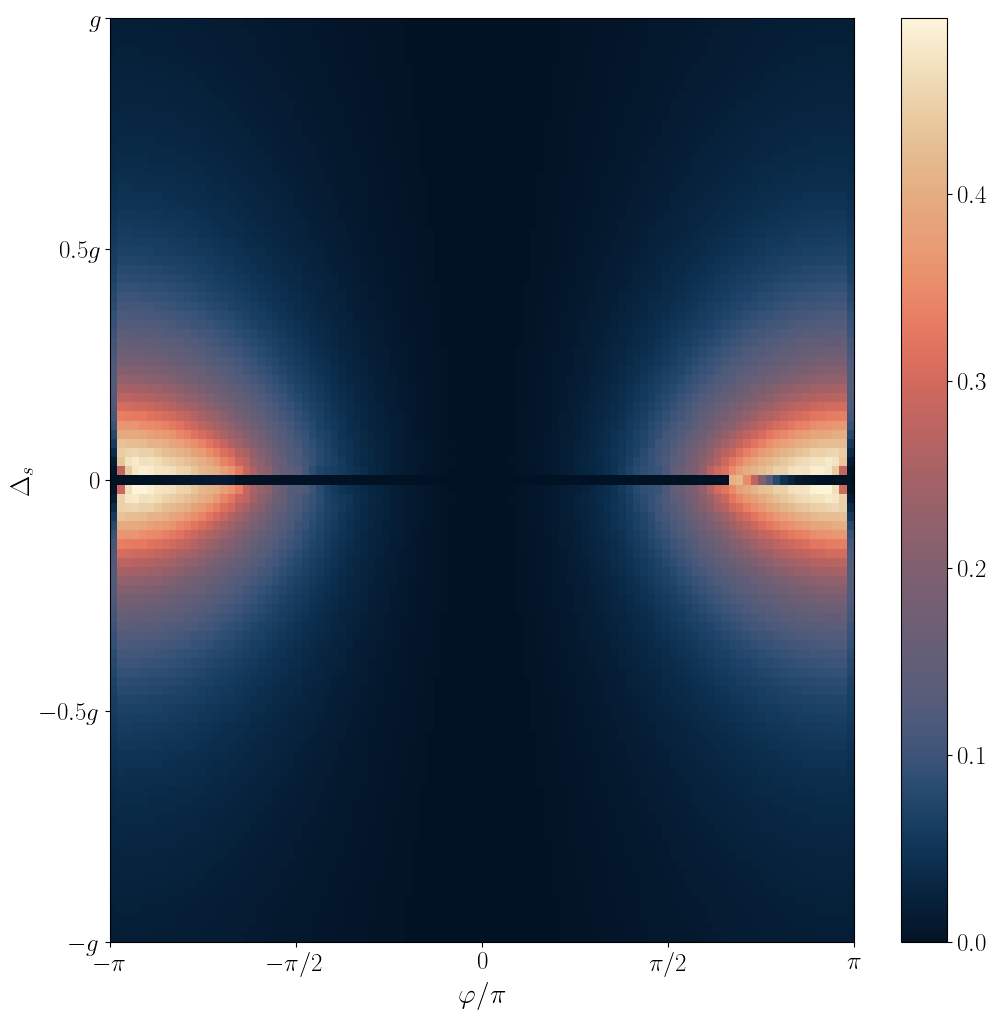

In [129]:
x = φ_vals./π
y = δ_vals./g
xtick_locs = [-1.0, -0.5, 0.0, 0.5, 1.0]  # x = φ/π
xtick_labels = [L"-\pi", L"-\pi/2", L"0", L"\pi/2", L"\pi"]
ytick_locs = [-1.0, -0.5, 0.0, 0.5, 1.0]  # x = φ/π
ytick_labels = [L"-g", L"-0.5g", L"0", L"0.5g", L"g"]
fig, ax = subplots(1, 1, figsize=(12, 12))

im1 = ax.imshow(var_sz1',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto", cmap=lipari)# vmin=-1, vmax=1)        # Use your defined colormap)
ax.set_ylabel(L"\Delta_s")
ax.set_xlabel(L"\varphi/\pi")
ax.set_xticks(xtick_locs)
ax.set_xticklabels(xtick_labels)
ax.set_yticks(ytick_locs)
ax.set_yticklabels(ytick_labels)

colorbar(im1, ax=ax)
display(fig)

Plotting frequency maxima

In [ ]:
# Fixed parameters (as before)
g, κ  = 0.1, 1.0
Δ1, Δ2 = 0.1g, 0.1g
Δ    = 0.0

# Time grid
tend  = 10000 / g
t_list = range(0.0, tend, length = 10_001)
dt     = t_list[2] - t_list[1]      # uniform timestep

# Initial state
u0c = [1, 0.0, 0, 1, 0.0, 0, 0, 0]

# Parameter ranges
η_vals = range(0.1 * g, 1.5 * g, length = 501)
φ_vals = range(-π, π, length = 501)

# “Steady‐state” index range: second half of the time‐series
# (divide the total number of points by 2; here length(t_list)=100001,
# so index ∼ 50001:100001)
steady_idx = collect(div(length(t_list), 2) : length(t_list))

# Preallocate arrays for the peak‐frequency of sz1 and sz2:
#   - dims: (length(φ_vals), length(η_vals))
fpeak_sz1 = zeros(Float64, length(φ_vals), length(η_vals))
fpeak_sz2 = zeros(Float64, length(φ_vals), length(η_vals))

# (Optional) if you ever want peak amplitudes too, you could do:
# apeak_sz1 = zeros(Float64, length(φ_vals), length(η_vals))
# apeak_sz2 = zeros(Float64, length(φ_vals), length(η_vals))

# Main double loop
for (iφ, φ) in enumerate(φ_vals)
    for (iη, η) in enumerate(η_vals)
        # (1) Build & solve the ODEProblem
        params = (Δ1, Δ2, g, φ, Δ, κ, η)
        prob = ODEProblem(coupled_eqs!, u0c, (0.0, tend), params)
        sol  = solve(prob, Tsit5(); saveat = t_list,
                              reltol = 1e-6, abstol = 1e-9)

        # (2) Extract the “steady‐state” window for sz1 and sz2
        sz1_window = sol[3, steady_idx]
        sz2_window = sol[6, steady_idx]

        # (3) FFT of each window
        fft_sz1 = fft(sz1_window)
        fft_sz2 = fft(sz2_window)

        # (4) Compute frequency‐axis parameters
        N = length(sz1_window)        # number of points in steady window
        df = 1.0 / (N * dt)           # frequency resolution
        Nhalf = div(N, 2)             # positive‐frequency bins are 1..Nhalf
                                      # (bin‐1 is DC, bins 2..Nhalf are f>0)

        #  (A) Discard the DC bin by zeroing it out:
        amp1 = abs.(fft_sz1)
        amp2 = abs.(fft_sz2)


        #  (B) Restrict to positive‐frequency half [2:Nhalf]
        #      (we skip index=1 since we forced it to zero above)
        pos_range = 1 : Nhalf

        # (5) Find the index (within pos_range) where amplitude is maximum
        #     Note: `argmax(amp1[pos_range])` returns a position in pos_range,
        #     so to recover the “global” index, do:
        fpeak_sz1[iφ, iη] = argmax(amp1[pos_range])
        fpeak_sz2[iφ, iη] = argmax(amp2[pos_range])

        # (Optional) If you also want to store the peak amplitude:
        # apeak_sz1[iφ, iη] = amp1[kpos1]
        # apeak_sz2[iφ, iη] = amp2[kpos2]
    end
end

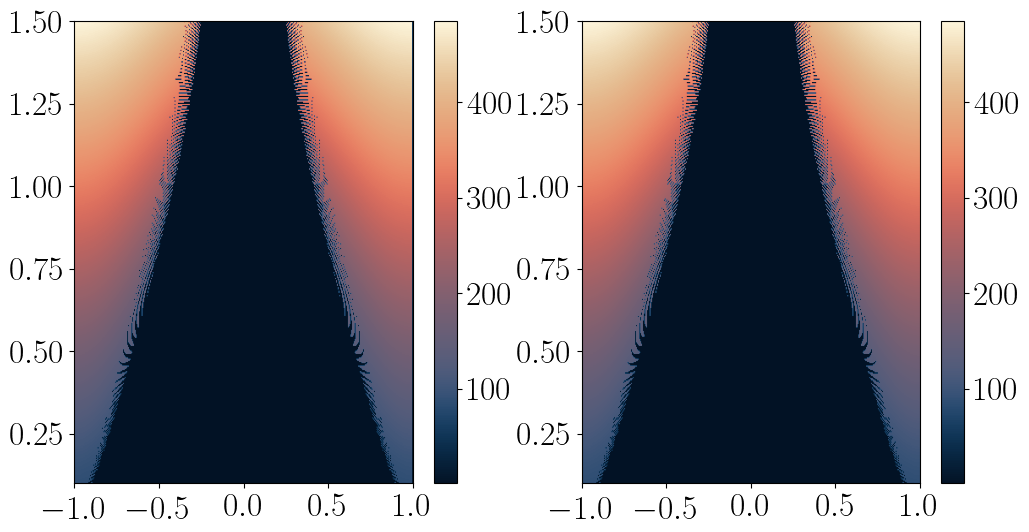

In [610]:
fig, ax = subplots(1, 2, figsize=(12, 6))

im1 = ax[1].imshow(fpeak_sz1',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto", cmap=lipari)        
im2 = ax[2].imshow(fpeak_sz2',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto", cmap=lipari)
colorbar(im1, ax=ax[1])
colorbar(im2, ax=ax[2])
display(fig)

In [515]:
# writedlm("../finsize_data/fourier_sznodet.txt", fpeak_sz1)
writedlm("fourier_szwdet.txt", fpeak_sz1)

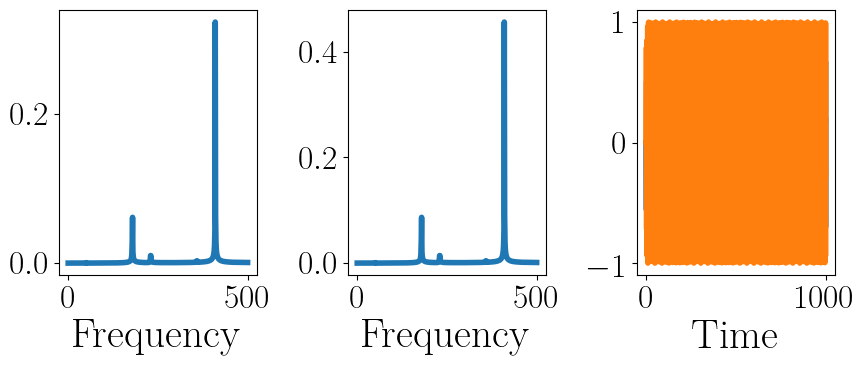

In [484]:

Δ = 0.0
ϕ = 3pi/4

κ = 1.0
g = 0.1*κ
η = 0.5*g
Δ1 = 0
Δ2 = 0
tend = 20000/g

t_list = range(0.0, tend, length=1000)

params = (Δ1, Δ2, g, ϕ, Δ, κ, η)
prob = ODEProblem(coupled_eqs!, u0c, (0,tend), params)
sol = solve(prob, Tsit5(), saveat=t_list, reltol=1e-6, abstol=1e-9)


sz1 = sol[3, :]   # index 3 corresponds to σᶻ₁
sz2 = sol[6, :]   # index 6 corresponds to σᶻ₂


N  = length(t_list)
dt = t_list[2] - t_list[1]    # assuming uniform spacing
fs = 100 / dt                 # sampling frequency

# Full FFTs
fft_sz1 = fft(sz1)
fft_sz2 = fft(sz2)

# Take only one side
fft_sz1 = fft_sz1[1:div(N, 2) + 1]
fft_sz2 = fft_sz2[1:div(N, 2) + 1]

P1_sz1 = abs.(fft_sz1[2:end]) ./ N
P1_sz2 = abs.(fft_sz2[2:end]) ./ N


fig, ax = subplots(1, 3, figsize = (9, 4))


ax[1].plot(P1_sz1, lw = 4)
ax[1].set_xlabel("Frequency")



ax[2].plot(P1_sz2, lw = 4)
ax[2].set_xlabel("Frequency")



ax[3].plot(sz1, lw = 4)
ax[3].plot(sz2, lw = 4)
ax[3].set_xlabel("Time")


tight_layout()
display(fig)



In [ ]:
# Normalize the data grids 


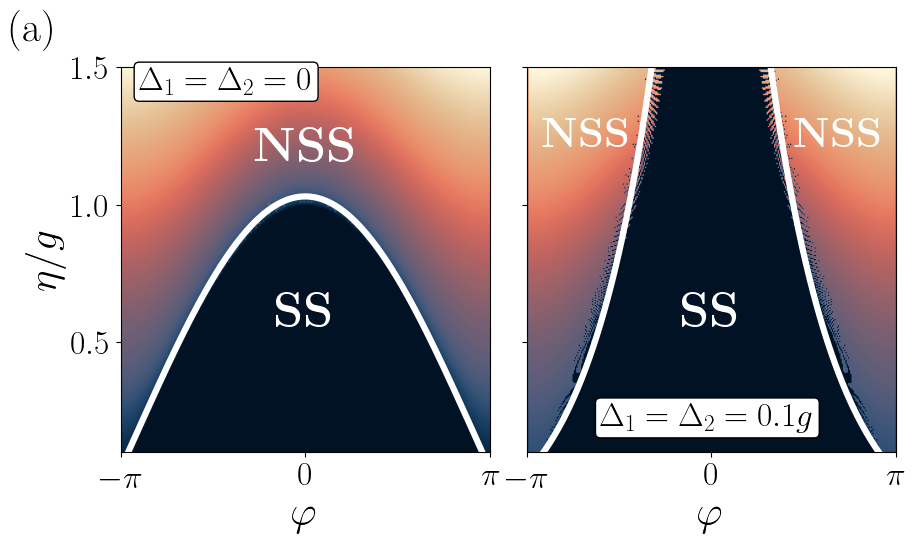

In [ ]:
x = φ_vals./π
y = η_vals./g

data1 = readdlm("fourier_sznodet.txt")
data2 = readdlm("fourier_szwdet.txt")

clims1 = (0,1)
clims2 = (0,1)

xtick_locs = [-1.0, 0.0, 1.0]  # x = φ/π
xtick_labels = [L"-\pi",L"0", L"\pi"]


fig, axs = subplots(1, 2, figsize=(10, 5))


im1 = axs[1].imshow(data1' ./ maximum(data1),
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto",
                     cmap=lipari,        # Use your defined colormap
                     clim=clims1)    # Color limits
axs[1].set_ylabel(L"\eta/g")
axs[1].set_xlabel(L"\varphi")
axs[1].set_xticks(xtick_locs)
axs[1].set_xticklabels(xtick_labels)
# cbar1 = colorbar(im1, ax=axs[1])
# cbar1.ax.set_title(L"\mathrm{Var}(s_1^z)", pad=13)
# cbar1.set_ticks([0.02, 0.3])
# cbar1.set_ticklabels([L"0", L"0.3"])

fncx = (0.88.* cos.(1.08 .*x .* pi/2) .+ 0.15)
axs[1].plot(x, fncx, color = "white", linewidth = 4.5)
axs[1].set_ylim(0.1,1.5)
axs[1].text(-0.3, 1.15, "(a)", transform=axs[1].transAxes, fontsize=30, fontweight="bold", va="top", ha="left")

axs[1].text(
    0.05, 1, L"\Delta_1=\Delta_2=0",
    transform = axs[1].transAxes,
    fontsize = 24,
    va = "top",
    ha = "left",
    bbox = Dict(
        "facecolor"  => "white",
        "edgecolor"  => "black",
        "boxstyle"   => "round,pad=0.15"
    )
)
axs[2].text(
    0.2, 0.05, L"\Delta_1=\Delta_2=0.1g",
    transform = axs[2].transAxes,
    fontsize = 24,
    va = "bottom",
    ha = "left",
    bbox = Dict(
        "facecolor"  => "white",
        "edgecolor"  => "black",
        "boxstyle"   => "round,pad=0.15"
    )
)


im1 = axs[2].imshow(data2' ./ maximum(data1),
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto",
                     cmap=lipari,        # Use your defined colormap
                     clim=(0,1))    # Color limits
axs[2].set_xlabel(L"\varphi")
axs[2].set_xticks(xtick_locs)
axs[2].set_xticklabels(xtick_labels)

#Remove y labels keeping only ticks from axs[2]
axs[2].set_yticklabels([])

#oush colorbar position to the right 


# cbar1 = colorbar(im1, ax=axs)
# cbar1.ax.set_title(L"\tilde{\omega}", pad=13)
# cbar1.set_ticks([0, 1])
# cbar1.set_ticklabels([L"0", L"1"])
# axs[2].text(-0.3, 1.15, "(b)", transform=axs[2].transAxes, fontsize=30, fontweight="bold", va="top", ha="left")

a = 4.25
b = 5.25
c = -0.25
fncx2 = a.*(exp.(-b.*abs.(x .* pi/6))) .+ c 


axs[2].plot(x, fncx2, color = "white", linewidth = 4.5) 
axs[2].set_ylim(0.1,1.5)


axs[1].text(0.0, 0.6, L"\textbf{SS}",
         fontsize = 35, ha = "center", va = "center", color = "white")
axs[1].text(0.0, 1.2, L"\textbf{NSS}",
         fontsize = 35, ha = "center", va = "center", color = "white")
axs[2].text(0.0, 0.6, L"\textbf{SS}",
         fontsize = 35, ha = "center", va = "center", color = "white")
axs[2].text(0.69, 1.25, L"\textbf{NSS}",
         fontsize = 30, ha = "center", va = "center", color = "white")
axs[2].text(-0.68, 1.25, L"\textbf{NSS}",
         fontsize = 30, ha = "center", va = "center", color = "white")

fig.subplots_adjust(wspace = 0.10)
# tight_layout()

# plt.savefig("phased_g,kap=01,1_Del=0_Ds=01.pdf", format="pdf", bbox_inches="tight")

display(fig)

#plt.savefig("../figs_for_paper/fig2.svg", bbox_inches="tight")
